### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 获取Mnist数据集
- 会自动进行下载

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision

In [3]:
train_data = torchvision.datasets.MNIST(
    root = "../../../../datas/minist",
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.5],std = [0.5])
    ])
) 

In [4]:
test_data = torchvision.datasets.MNIST(
    root = "../../../../datas/minist",
    train = False,
    download = True,
        transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean = [0.5],std = [0.5])
    ])
) 

(-0.5, 27.5, 27.5, -0.5)

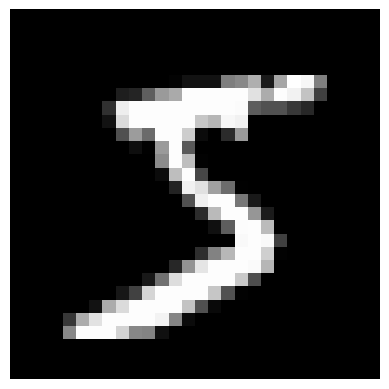

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = np.array(train_data.data[0])
plt.imshow(img,cmap="gray")
plt.axis("off")

784是mnist数据集每个样本的像素点个数

In [6]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [7]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [8]:
test_data.data.shape

torch.Size([10000, 28, 28])

### 创建一个model来简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [9]:
from torch import nn

class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.model1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2,kernel_size=2),
        )
        self.model2 = torch.nn.Sequential(
            torch.nn.Linear(14*14*128,1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(1024, 10)
        )
    def forward(self,x):
        x = self.model1(x)
        x = x.view(-1, 14*14*128)
        x = self.model2(x)
        return x
        

In [10]:
model = Model()
print(model)

Model(
  (model1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (model2): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


可以打印我们定义好名字里的权重和偏置项

In [11]:
for name, parameter in model.named_parameters():
    print(name, parameter,parameter.size())

model1.0.weight Parameter containing:
tensor([[[[-0.3319,  0.1322,  0.2586],
          [-0.2581,  0.2516,  0.1719],
          [ 0.3214, -0.1892,  0.1845]]],


        [[[-0.2846,  0.0054,  0.0674],
          [ 0.1867,  0.1668, -0.2712],
          [ 0.2959, -0.0673,  0.3141]]],


        [[[-0.0762,  0.0697, -0.2629],
          [-0.2321,  0.3319,  0.0083],
          [ 0.0552,  0.3173,  0.2354]]],


        [[[ 0.1740, -0.1064,  0.3242],
          [ 0.0280,  0.0231,  0.2484],
          [ 0.2695,  0.2927, -0.1349]]],


        [[[ 0.2785,  0.2296, -0.2079],
          [-0.0723,  0.0534,  0.2601],
          [-0.2272,  0.2131, -0.1736]]],


        [[[ 0.2924, -0.1593,  0.3127],
          [ 0.2264, -0.2281, -0.2812],
          [ 0.3004, -0.1223,  0.2428]]],


        [[[-0.0025,  0.0774,  0.1458],
          [-0.0057, -0.0682, -0.3179],
          [-0.0404, -0.2575,  0.2684]]],


        [[[ 0.1210, -0.0017,  0.1847],
          [ 0.2671, -0.2817, -0.1239],
          [ 0.1921, -0.0618, -0.2144]

### 使用TensorDataset和DataLoader来简化

In [12]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# train_data = TensorDataset(train_data.data, train_data.targets)
train_load = DataLoader(train_data, batch_size=64,num_workers=4,pin_memory=True, shuffle=True)

# test_data = TensorDataset(test_data.data, test_data.targets)
test_load = DataLoader(test_data,num_workers=4,pin_memory=True,batch_size=64)

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
epoch = 5
test_data_size = len(test_data)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model()
model.to(device)
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [14]:
for i in range(epoch):
    print("-------------第{}轮训练开始------------".format(i+1))
    # 训练步骤开始
    model.train()
    for data in train_load:
        imgs,targets = data
        imgs = imgs.to(device)
        targets = targets.to(device)
        outputs = model(imgs)
        loss = loss_fn(outputs,targets)
        
        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("训练轮数：{},loss:{}".format(i,loss.item()))
        
    # 测试步骤
    model.eval()
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in test_load:
            imgs,targets = data
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs,targets)
            total_test_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy+=accuracy
    print("整体测试集上的loss:{}".format(total_test_loss))
    print("整体测试集上的正确率:{}".format(total_accuracy/test_data_size))


-------------第1轮训练开始------------
训练轮数：0,loss:0.3388301730155945
整体测试集上的loss:21.92917632125318
整体测试集上的正确率:0.9594999551773071
-------------第2轮训练开始------------
训练轮数：1,loss:0.018558554351329803
整体测试集上的loss:19.725693436339498
整体测试集上的正确率:0.9610999822616577
-------------第3轮训练开始------------
训练轮数：2,loss:0.5019228458404541
整体测试集上的loss:18.44894193392247
整体测试集上的正确率:0.9634999632835388
-------------第4轮训练开始------------
训练轮数：3,loss:0.2557317912578583
整体测试集上的loss:20.41144162652199
整体测试集上的正确率:0.9617999792098999
-------------第5轮训练开始------------
训练轮数：4,loss:0.39774876832962036
整体测试集上的loss:19.16067609115271
整体测试集上的正确率:0.9677000045776367
